In [23]:
import praw

reddit = praw.Reddit(
    client_id="mes9gWc63dQExDQSII2ugA",
    client_secret="	i5ebc9VoXHkW7N4Xg0MopbVTJmE4UQ",
    user_agent="msrp_scraper",
    username="KrytZ09",
    password="MIGSISW1NN3R",
)

In [26]:
print(reddit.user.me())

ResponseException: received 401 HTTP response

In [24]:
print(reddit.read_only)

False


In [25]:
for submission in reddit.subreddit("test").hot(limit=10):
    print(submission.title)

ResponseException: received 401 HTTP response

In [ ]:
for submission in reddit.subreddit("test").hot(limit=10):
    print(submission.title)

ResponseException: received 401 HTTP response

In [4]:
subreddit = reddit.subreddit("redditdev")

print(subreddit.display_name)
# Output: redditdev
print(subreddit.title)
# Output: reddit development
print(subreddit.description)

redditdev


ResponseException: received 401 HTTP response

# HERE

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
# Start Spark
spark = (
    SparkSession.builder
    .appName("AmazonReviewsSample")
    .master("local[*]")
    .getOrCreate()
)

In [6]:
df = spark.read.parquet('aita_train.parquet')

In [8]:
df.count()

60709

In [10]:
df.columns

['id', 'title', 'text', 'verdict', 'comment1', 'comment2', 'score']

    so 60709 rows and 6 columns but honestly only need 3 colums [title, text, verdict]

In [11]:
filtered_df = df.select('title', 'text', 'verdict')

In [15]:
verdict_counts = (df
                  .groupby('verdict')
                  .agg(
                      F.count('*').alias('verdict_count'))
                  .orderBy('verdict_count')
                  .toPandas()
                 )

In [16]:
verdict_counts

,verdict,verdict_count
0,esh,1008
1,nah,1231
2,yta,8209
3,nta,50261


/tmp/ipykernel_120388/2147903225.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


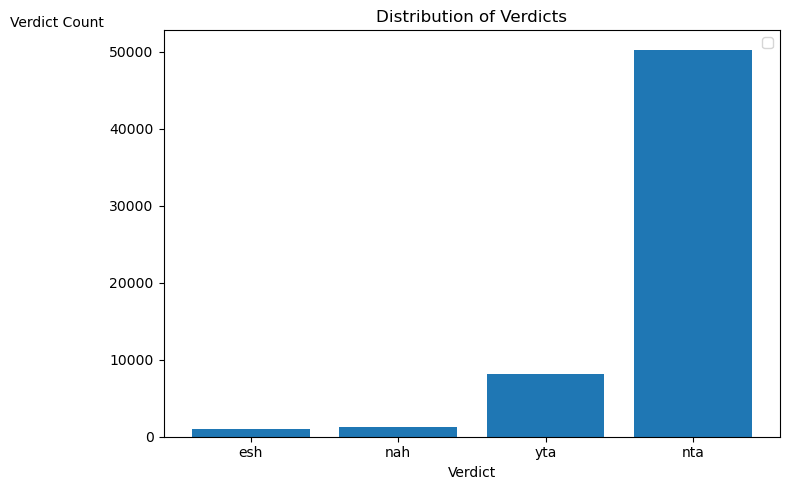

In [19]:
plt.figure(figsize=(8,5))
plt.bar(verdict_counts['verdict'], verdict_counts['verdict_count'])

plt.title("Distribution of Verdicts")
plt.xlabel("Verdict")
plt.ylabel("Verdict Count", rotation=0, loc="top")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
labels = df['verdict']  # convert verdict to numeric labels (0–3)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights

In [ ]:
from transformers import pipeline